In [1]:
# Installation et configuration initiale
#!python -m pip install cityscapesscripts

In [2]:
import fonctions as fc
import importlib
importlib.reload(fc)

import random
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np

from pathlib import Path
from cityscapesscripts.preparation import json2labelImg
from fonctions import iou_coef, mean_iou, dice_coef, weighted_mean_iou
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from fonctions import unet_mini, entrainer_modele, unet_vgg16, unet_resnet50, unet_efficientnetb3
from tensorflow.keras.optimizers import Adam

Segmentation Models: using `keras` framework.


c:\Users\icema\OpenClassrooms\AI_Engineer\venv8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# =============================
# 📁 1. Définition des chemins
# =============================
root_path = Path("C:/Users/icema/OpenClassrooms/AI_Engineer/venv8")
data_path = root_path / "data"
cityscapes_scripts_path = root_path / "notebooks/cityscapesScripts/cityscapesscripts"
images_path = data_path / "leftImg8bit"
masks_path = data_path / "gtFine"

# Définition des sous-dossiers
train_images_path = images_path / "train"
val_images_path = images_path / "val"
train_masks_path = masks_path / "train"
val_masks_path = masks_path / "val"

# Vérification des dossiers
for path in [train_images_path, val_images_path, train_masks_path, val_masks_path]:
    if not path.exists():
        print(f"⚠️ Attention : {path} n'existe pas. Vérifie que les fichiers sont bien placés.")
    else:
        print(f"✅ Dossier trouvé : {path}")

✅ Dossier trouvé : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\leftImg8bit\train
✅ Dossier trouvé : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\leftImg8bit\val
✅ Dossier trouvé : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\gtFine\train
✅ Dossier trouvé : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\gtFine\val


In [4]:
# Recherche des images et des masques
train_input_img_paths = sorted([str(p) for p in train_images_path.rglob("*.png")])
val_input_img_paths = sorted([str(p) for p in val_images_path.rglob("*.png")])

train_label_ids_img_paths = sorted([str(p) for p in train_masks_path.rglob("*/*_labelIds.png")])  # Recherche dans sous-dossiers
val_label_ids_img_paths = sorted([str(p) for p in val_masks_path.rglob("*/*_gtFine_labelIds.png")])  # Recherche dans sous-dossiers

# Vérification du nombre de fichiers trouvés
print(f"\n📂 {len(train_input_img_paths)} images d'entraînement trouvées.")
print(f"📂 {len(train_label_ids_img_paths)} masques d'entraînement trouvés.")
print(f"📂 {len(val_input_img_paths)} images de validation trouvées.")
print(f"📂 {len(val_label_ids_img_paths)} masques de validation trouvés.")

# Vérification des correspondances
assert len(train_input_img_paths) == len(train_label_ids_img_paths), "⚠️ Désalignement entre images et masques d'entraînement !"
assert len(val_input_img_paths) == len(val_label_ids_img_paths), "⚠️ Désalignement entre images et masques de validation !"

print("✅ Fichiers correctement alignés.")


📂 2975 images d'entraînement trouvées.
📂 2975 masques d'entraînement trouvés.
📂 500 images de validation trouvées.
📂 500 masques de validation trouvés.
✅ Fichiers correctement alignés.


In [5]:
# Vérification des fichiers JSON (annotations)
train_json_paths = sorted([str(p) for p in train_masks_path.rglob("*.json")])
val_json_paths = sorted([str(p) for p in val_masks_path.rglob("*.json")])

print(f"\n📜 {len(train_json_paths)} fichiers JSON trouvés pour l'entraînement.")
print(f"📜 {len(val_json_paths)} fichiers JSON trouvés pour la validation.")


📜 2975 fichiers JSON trouvés pour l'entraînement.
📜 500 fichiers JSON trouvés pour la validation.


In [6]:
# Si aucun masque n'est trouvé mais que des fichiers JSON existent, on les convertit en masques
if len(train_label_ids_img_paths) == 0 and len(train_json_paths) > 0:
    print("\n🛠️ Génération des masques d'entraînement à partir des fichiers JSON...")
    os.system(f'python {cityscapes_scripts_path}/preparation/json2labelImg.py '
            f'--input_path "{train_masks_path}" --output_path "{train_masks_path}"')

if len(val_label_ids_img_paths) == 0 and len(val_json_paths) > 0:
    print("\n🛠️ Génération des masques de validation à partir des fichiers JSON...")
    os.system(f'python {cityscapes_scripts_path}/preparation/json2labelImg.py '
            f'--input_path "{val_masks_path}" --output_path "{val_masks_path}"')

print("\n✅ Vérification et correction terminées !")


✅ Vérification et correction terminées !


In [7]:
# Affichage des dossiers
print("\nStructure du dossier des images :")
fc.view_folder(images_path)


Structure du dossier des images :
|-- test
    |-- berlin
    |-- bielefeld
    |-- bonn
    |-- leverkusen
    |-- mainz
    |-- munich
|-- train
    |-- aachen
    |-- bochum
    |-- bremen
    |-- cologne
    |-- darmstadt
    |-- dusseldorf
    |-- erfurt
    |-- hamburg
    |-- hanover
    |-- jena
    |-- krefeld
    |-- monchengladbach
    |-- strasbourg
    |-- stuttgart
    |-- tubingen
    |-- ulm
    |-- weimar
    |-- zurich
|-- val
    |-- frankfurt
    |-- lindau
    |-- munster


In [8]:
print("\nStructure du dossier des masques :")
fc.view_folder(masks_path)


Structure du dossier des masques :
|-- test
    |-- berlin
    |-- bielefeld
    |-- bonn
    |-- leverkusen
    |-- mainz
    |-- munich
|-- train
    |-- aachen
    |-- bochum
    |-- bremen
    |-- cologne
    |-- darmstadt
    |-- dusseldorf
    |-- erfurt
    |-- hamburg
    |-- hanover
    |-- jena
    |-- krefeld
    |-- monchengladbach
    |-- strasbourg
    |-- stuttgart
    |-- tubingen
    |-- ulm
    |-- weimar
    |-- zurich
|-- val
    |-- frankfurt
    |-- lindau
    |-- munster


📸 Image sélectionnée : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\leftImg8bit\train\cologne\cologne_000086_000019_leftImg8bit.png
🔹 Label trouvé : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\gtFine\train\cologne\cologne_000086_000019_gtFine_labelIds.png


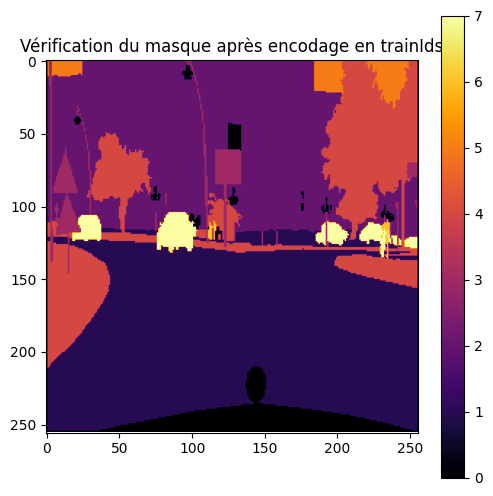

Classes présentes dans le masque : {0: 4116, 1: 26886, 2: 19131, 3: 1738, 4: 10925, 5: 1212, 6: 118, 7: 1410}


In [9]:
# Recherche des images d'entraînement
image_files = list(train_images_path.rglob("*.png"))

if not image_files:
    raise FileNotFoundError("Aucune image trouvée dans le dossier 'train'.")

# Sélectionner une image aléatoire
selected_image_path = random.choice(image_files)
print(f"📸 Image sélectionnée : {selected_image_path}")

# Extraction du nom de base
base_name = selected_image_path.name.replace("_leftImg8bit.png", "")

# Recherche des fichiers correspondants
image_label = next(train_masks_path.rglob(f"{base_name}_gtFine_labelIds.png"), None)
image_color = next(train_masks_path.rglob(f"{base_name}_gtFine_color.png"), None)

if image_label:
    print(f"🔹 Label trouvé : {image_label}")
else:
    print(f"❌ Aucune annotation trouvée pour {base_name}.")

# Vérification d'un masque après encodage en trainIds
sample_mask_path = train_label_ids_img_paths[0]
sample_mask = fc.load_mask(sample_mask_path, target_size=(256, 256))

plt.figure(figsize=(6, 6))
plt.imshow(sample_mask, cmap="inferno")
plt.colorbar()
plt.title("Vérification du masque après encodage en trainIds")
plt.show()

# Vérifier les classes présentes dans le masque
unique_classes, counts = np.unique(sample_mask, return_counts=True)
print("Classes présentes dans le masque :", dict(zip(unique_classes, counts)))

In [10]:
# Chemin du fichier JSON correspondant
image_json = next(train_masks_path.rglob(f"{base_name}_gtFine_polygons.json"), None)

if image_json:
    image_train = image_json.parent / f"{base_name}_gtFine_trainIds.png"
    try:
        json2labelImg.json2labelImg(image_json, image_train, encoding="trainIds")
        print(f"✅ Image générée : {image_train}")
    except Exception as e:
        print(f"❌ Erreur lors de la conversion : {e}")
else:
    print(f"❌ Aucun fichier JSON trouvé pour {base_name}")

✅ Image générée : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\gtFine\train\cologne\cologne_000086_000019_gtFine_trainIds.png


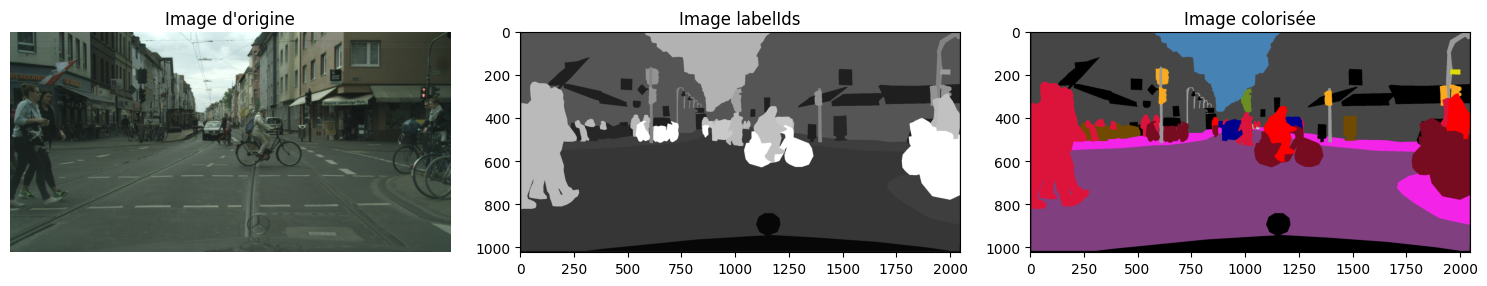

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Image originale
img = mpimg.imread(selected_image_path)
axes[0].imshow(img)
axes[0].set_title("Image d'origine")
axes[0].axis('off')

# Image avec les labels (niveau de gris)
if image_label:
    img_label = mpimg.imread(image_label)
    axes[1].imshow(img_label, cmap='gray')
    axes[1].set_title("Image labelIds")
else:
    axes[1].axis('off')

# Image colorisée
if image_color:
    img_color = mpimg.imread(image_color)
    axes[2].imshow(img_color)
    axes[2].set_title("Image colorisée")
else:
    axes[2].axis('off')

plt.tight_layout()
plt.show()

✅ Image sélectionnée : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\leftImg8bit\val\lindau\lindau_000043_000019_leftImg8bit.png
✅ Masque correspondant : C:\Users\icema\OpenClassrooms\AI_Engineer\venv8\data\gtFine\val\lindau\lindau_000043_000019_gtFine_labelIds.png


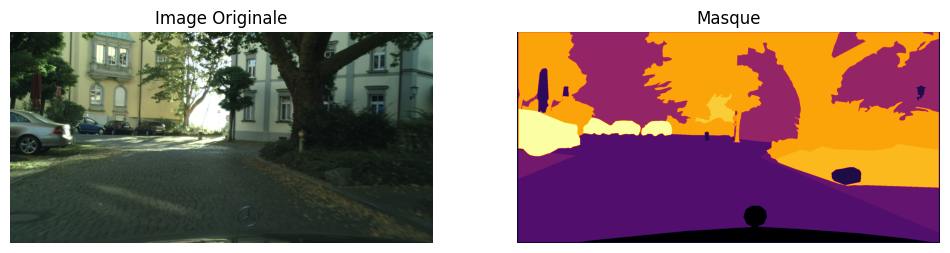

In [12]:
# Sélection d'une image aléatoire dans le jeu de validation
random_image_path = random.choice(val_input_img_paths)
base_name = Path(random_image_path).stem.replace("_leftImg8bit", "")  # Récupérer le nom de base

# Trouver le masque correspondant
corresponding_mask_path = next((p for p in val_label_ids_img_paths if base_name in p), None)

# Vérification
if not corresponding_mask_path:
    print(f"❌ Aucun masque trouvé pour {random_image_path}")
else:
    print(f"✅ Image sélectionnée : {random_image_path}")
    print(f"✅ Masque correspondant : {corresponding_mask_path}")

    # Charger les images
    img = mpimg.imread(random_image_path)
    mask = mpimg.imread(corresponding_mask_path)

    # Affichage des images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img)
    axes[0].set_title("Image Originale")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="inferno")
    axes[1].set_title("Masque")
    axes[1].axis("off")

    plt.show()

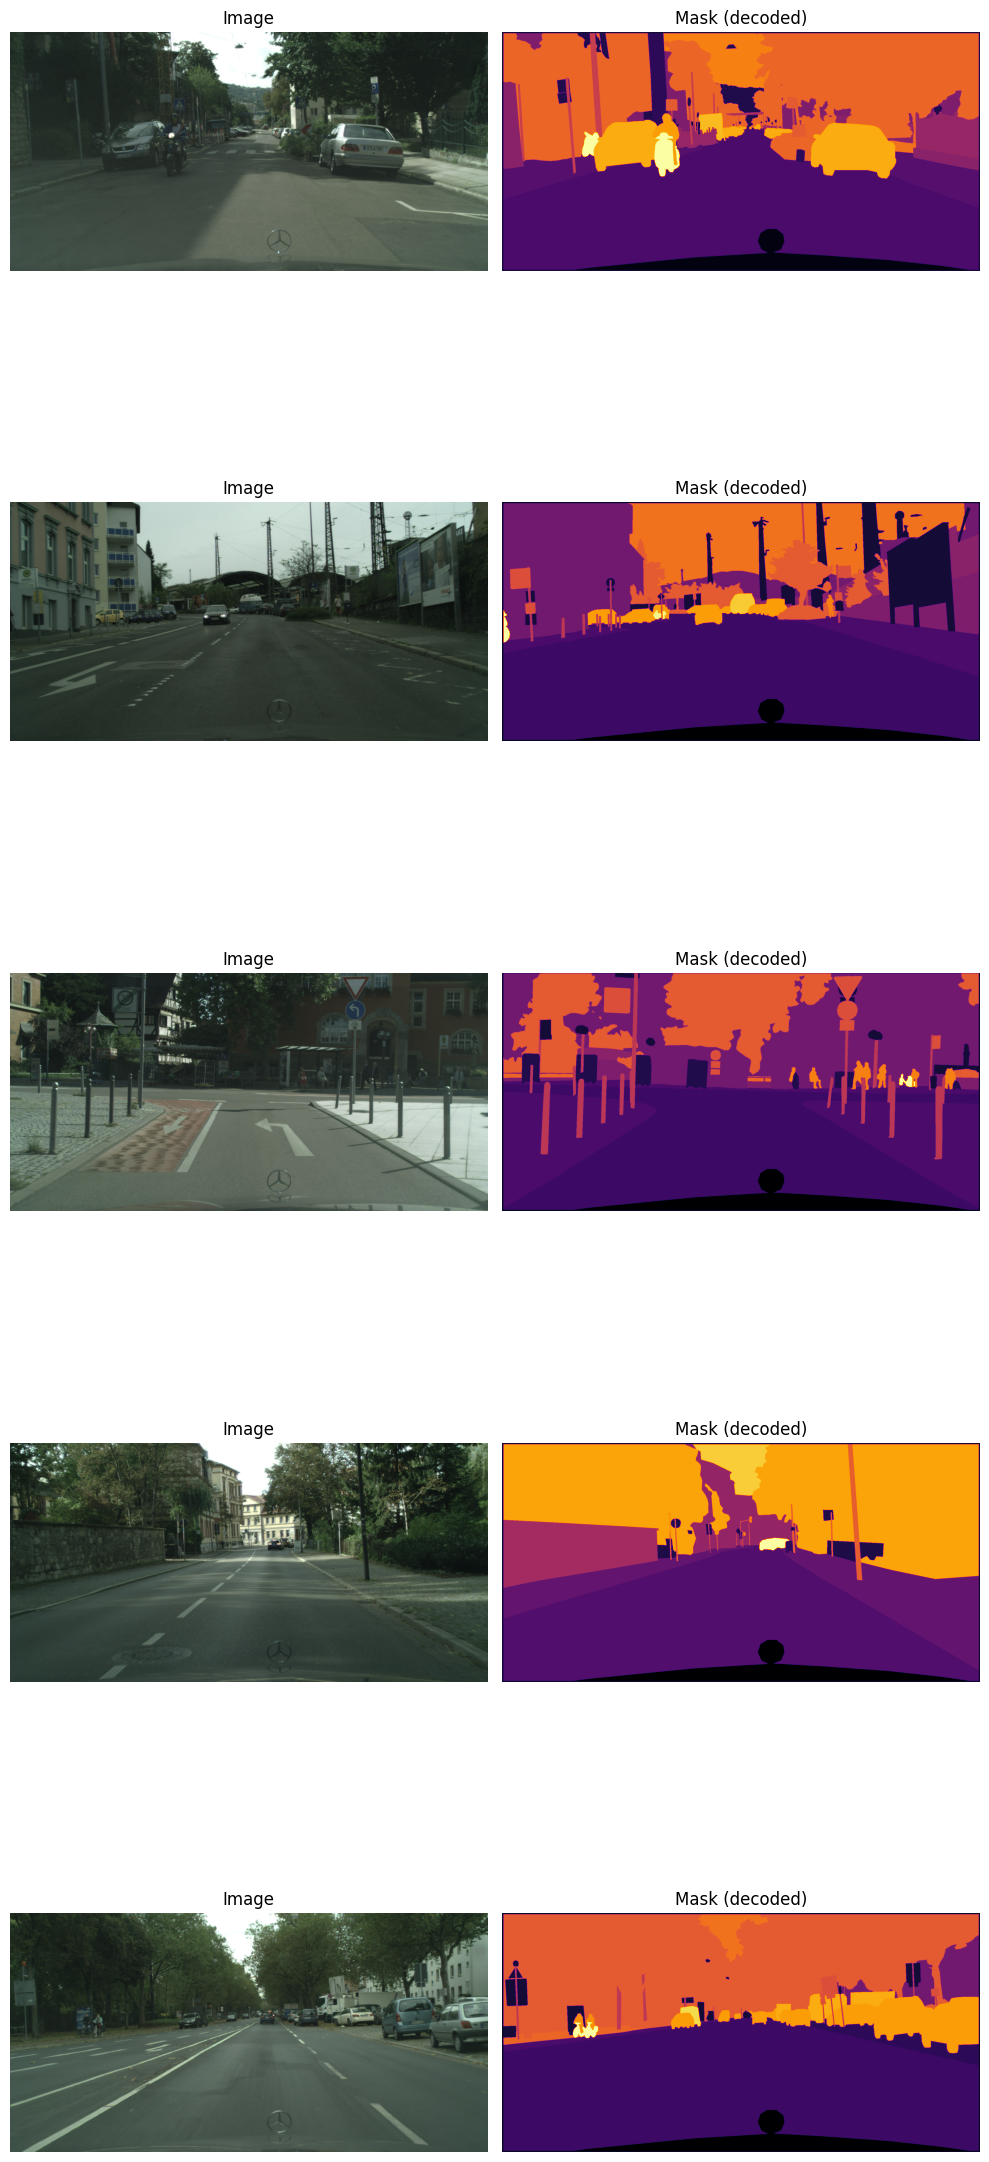

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Sélectionner un nouvel échantillon aléatoire
num_samples = 5  # Nombre d'images à afficher
random_indices = random.sample(range(len(train_input_img_paths)), num_samples)

# Affichage des images et des masques
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

for i, idx in enumerate(random_indices):
    # Charger l'image et le masque correspondant
    image_path = train_input_img_paths[idx]
    mask_path = train_label_ids_img_paths[idx]

    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Convertir le masque en numpy pour affichage avec une colormap
    mask_array = np.array(mask)

    # Affichage de l'image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    # Affichage du masque avec une colormap adaptée
    axes[i, 1].imshow(mask_array, cmap="inferno")
    axes[i, 1].set_title("Mask (decoded)")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [14]:
from fonctions import DataGenerator

# Création du générateur de données pour l'entraînement
train_generator = DataGenerator(
    image_paths=train_input_img_paths,
    mask_paths=train_label_ids_img_paths,
    image_size=(256, 256),  # Taille des images/masks
    batch_size=8,
    num_classes=8,
    shuffle=True,
    augmentation_ratio=0.5  # 50% des images subiront des augmentations
)

# Création du générateur de données pour la validation (sans augmentation)
val_generator = DataGenerator(
    image_paths=val_input_img_paths,
    mask_paths=val_label_ids_img_paths,
    image_size=(512, 512),
    batch_size=8,
    num_classes=8,
    shuffle=False,
    augmentation_ratio=0  # Pas d'augmentation pour la validation
)

In [15]:
import importlib
import fonctions as fc
importlib.reload(fc)

# Vérification avec une image d'entraînement
sample_mask = fc.load_mask(train_label_ids_img_paths[0], target_size=(256, 256))

# Vérifier les classes présentes après correction
print("✅ Classes présentes après remapping :", np.unique(sample_mask))

# Vérification avec un batch entier
batch_images, batch_masks = train_generator[0]
print("✅ Classes uniques dans les masques après correction :", np.unique(np.argmax(batch_masks, axis=-1)))

✅ Classes présentes après remapping : [0 1 2 3 4 5 6 7]
✅ Classes uniques dans les masques après correction : [0 1 2 3 4 5 6 7]


In [16]:
import json
import os

# Charger un fichier JSON d'annotation
json_file = train_label_ids_img_paths[0].replace("_gtFine_labelIds.png", "_gtFine_polygons.json")
with open(json_file, "r") as f:
    data = json.load(f)

# Vérifier les classes présentes dans ce JSON
categories = set([obj["label"] for obj in data["objects"]])
print(f"Classes présentes dans le JSON après correction : {categories}")

Classes présentes dans le JSON après correction : {'traffic sign', 'pole', 'person', 'road', 'sky', 'license plate', 'rider', 'car', 'vegetation', 'ego vehicle', 'bicycle', 'static', 'sidewalk', 'building', 'terrain', 'out of roi'}


In [17]:
# Charger un batch d'exemple depuis le générateur d'entraînement
batch_images, batch_masks = train_generator[0]

print(f"✅ Dimensions du batch d'images : {batch_images.shape}")
print(f"✅ Dimensions du batch de masques : {batch_masks.shape}")

✅ Dimensions du batch d'images : (8, 256, 256, 3)
✅ Dimensions du batch de masques : (8, 256, 256, 8)


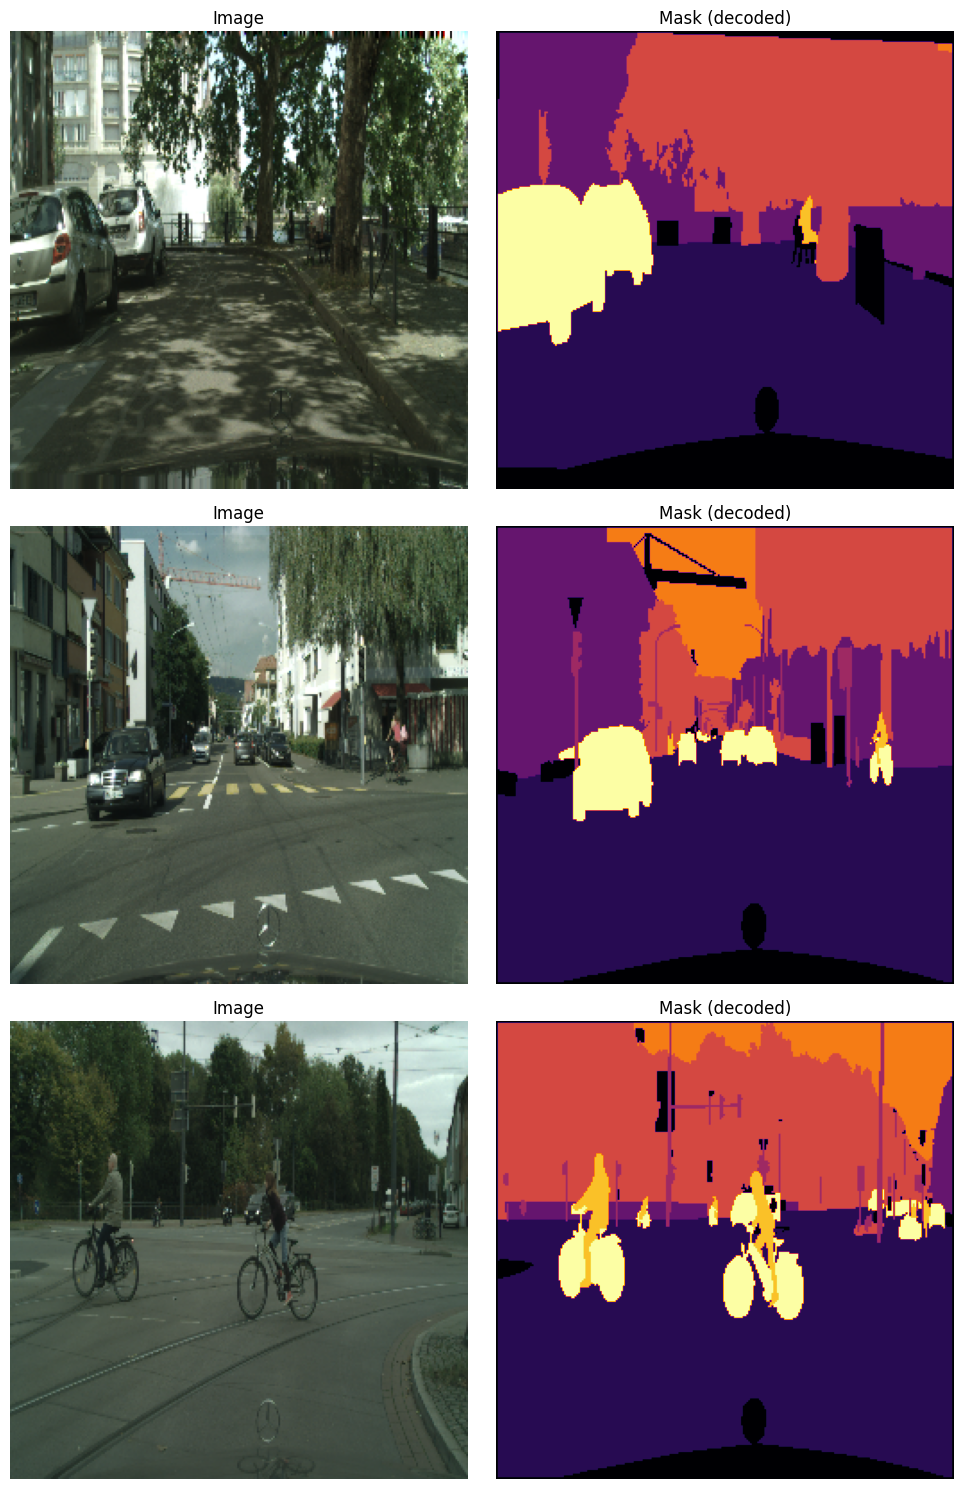

In [18]:
train_generator.visualize_batch(num_images=3)

In [19]:
import importlib
import fonctions as fc
importlib.reload(fc)

# Charger une image et son masque
sample_mask = fc.load_mask(train_label_ids_img_paths[0], target_size=(256, 256))

# Vérifier les classes présentes
print("✅ Classes présentes après remapping :", np.unique(sample_mask))

✅ Classes présentes après remapping : [0 1 2 3 4 5 6 7]


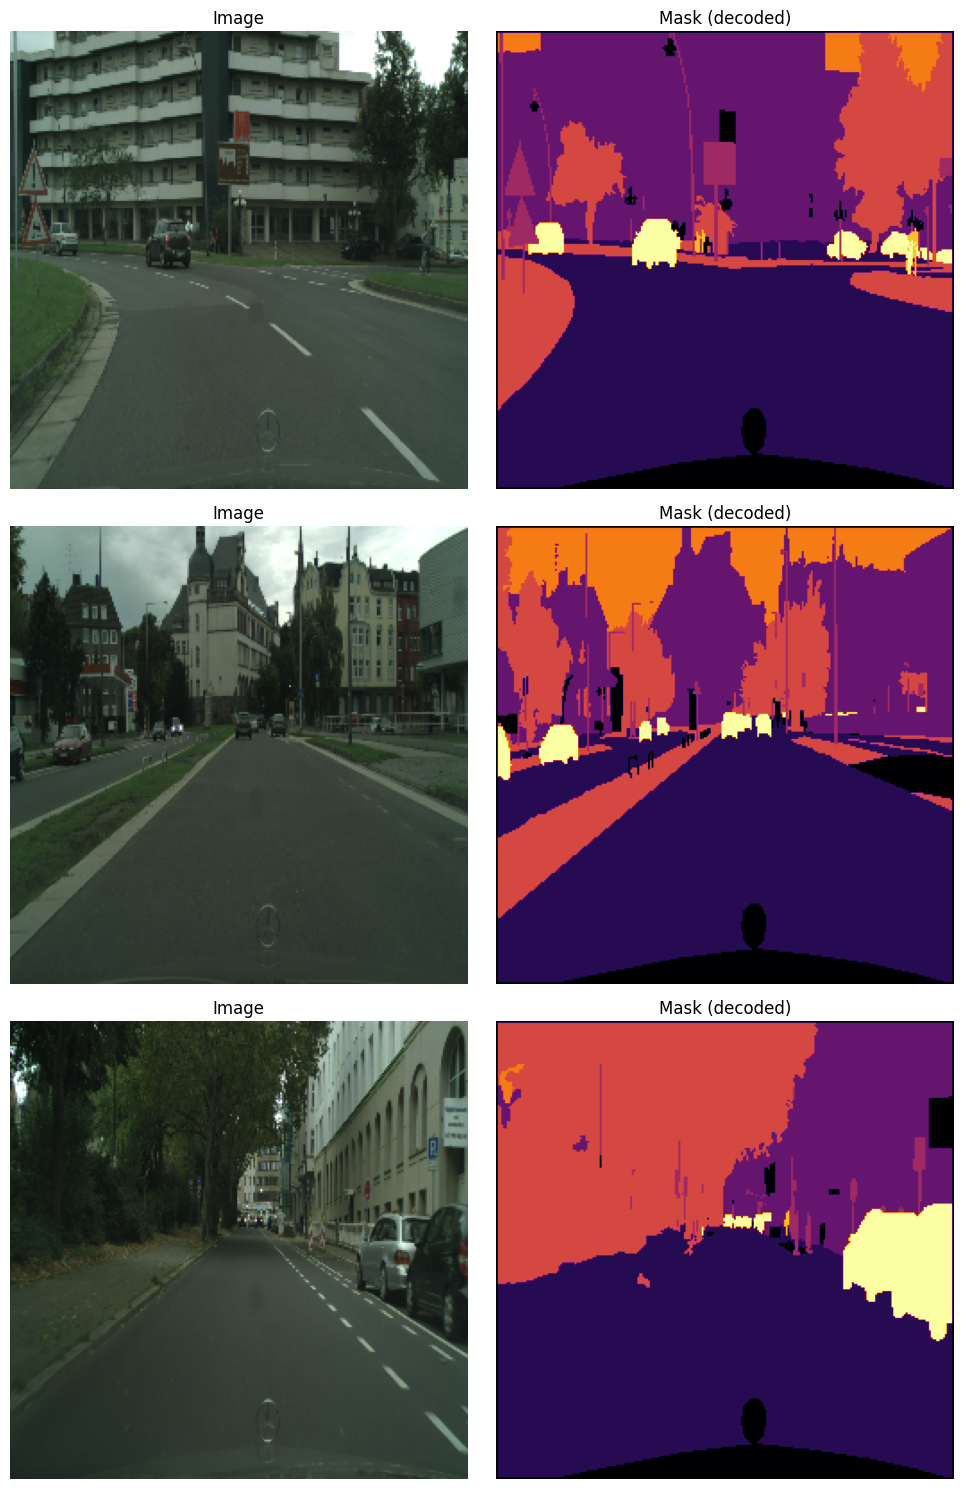

In [20]:
# Charger un batch sans augmentation
train_generator_no_aug = DataGenerator(
    image_paths=train_input_img_paths,
    mask_paths=train_label_ids_img_paths,
    image_size=(256, 256),
    batch_size=64,
    num_classes=8,
    shuffle=False,
    augmentation_ratio=0  # Désactivation des augmentations
)

# Visualisation du batch brut
train_generator_no_aug.visualize_batch(num_images=3)

In [21]:
# Exemple de masques factices (batch_size=1, image_size=4x4, num_classes=8)
y_true = np.random.randint(0, 2, (1, 4, 4, 8)).astype(np.float32)  # Masque réel (one-hot)
y_pred = np.random.rand(1, 4, 4, 8).astype(np.float32)  # Prédiction aléatoire entre 0 et 1

# Calcul des métriques
iou_score = iou_coef(y_true, y_pred)
mean_iou_score = mean_iou(y_true, y_pred)
dice_score = dice_coef(y_true, y_pred)

# Affichage des résultats
print(f"IoU : {tf.keras.backend.eval(iou_score):.4f}")
print(f"Mean IoU : {tf.keras.backend.eval(mean_iou_score):.4f}")
print(f"Dice Coefficient : {tf.keras.backend.eval(dice_score):.4f}")

IoU : 0.2779
Mean IoU : 0.2777
Dice Coefficient : 0.4349


In [22]:
iou_weighted = fc.weighted_mean_iou(y_true, y_pred)
print(f"Weighted Mean IoU (avec pénalité sur 'person') : {tf.keras.backend.eval(iou_weighted):.4f}")

Weighted Mean IoU (avec pénalité sur 'person') : 0.3532


In [23]:
# 🔍 Réduction du dataset pour accélérer l'entraînement
reduced_train_img_paths = train_input_img_paths[:2000]
reduced_train_mask_paths = train_label_ids_img_paths[:2000]

reduced_val_img_paths = val_input_img_paths[:500]
reduced_val_mask_paths = val_label_ids_img_paths[:500]

# Création des générateurs réduits
train_gen_reduit = DataGenerator(
    reduced_train_img_paths, reduced_train_mask_paths,
    batch_size=64, image_size=(256,256), augmentation_ratio=0.5)

val_gen_reduit = DataGenerator(
    reduced_val_img_paths, reduced_val_mask_paths,
    batch_size=64, image_size=(256,256), augmentation_ratio=0)

print(f"📂 Jeu réduit : {len(reduced_train_img_paths)} images pour l'entraînement, {len(reduced_val_img_paths)} pour la validation.")

📂 Jeu réduit : 2000 images pour l'entraînement, 500 pour la validation.


## Modèle Simple

### Unet_Mini (Simple sans backbone pré-entrainé)

In [ ]:
# Création du modèle unet_mini
model_mini = unet_mini(input_shape=(256,256,3), num_classes=8)

# Compilation du modèle
model_mini.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[mean_iou, dice_coef, "accuracy"]
)

# Entraînement sur le dataset réduit
history_mini = entrainer_modele(
    model=model_mini,
    train_generator=train_gen_reduit,
    val_generator=val_gen_reduit,
    epochs=50,
    patience=5
)

'# Création du modèle unet_mini\nmodel_mini = unet_mini(input_shape=(256,256,3), num_classes=8)\n\n# Compilation du modèle\nmodel_mini.compile(\n    optimizer="adam",\n    loss="categorical_crossentropy",\n    metrics=[mean_iou, dice_coef, "accuracy"]\n)\n\n# Entraînement sur le dataset réduit\nhistory_mini = entrainer_modele(\n    model=model_mini,\n    train_generator=train_gen_reduit,\n    val_generator=val_gen_reduit,\n    epochs=50,\n    patience=5\n)'

## Modèle Avancée

### Unet_vgg16 (pré-entrainée avec encodeur vgg16 via segmentation_models)

In [ ]:
# Création du modèle VGG16
model_vgg16 = unet_vgg16(input_shape=(256,256,3), num_classes=8)

# Compilation du modèle
model_vgg16.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[mean_iou, dice_coef, "accuracy"]
)

# Entraînement sur le dataset réduit
history_vgg16 = entrainer_modele(
    model=model_vgg16,
    train_generator=train_gen_reduit,
    val_generator=val_gen_reduit,
    epochs=50,
    patience=5
)

'# Création du modèle VGG16\nmodel_vgg16 = unet_vgg16(input_shape=(256,256,3), num_classes=8)\n\n# Compilation du modèle\nmodel_vgg16.compile(\n    optimizer="adam",\n    loss="categorical_crossentropy",\n    metrics=[mean_iou, dice_coef, "accuracy"]\n)\n\n# Entraînement sur le dataset réduit\nhistory_vgg16 = entrainer_modele(\n    model=model_vgg16,\n    train_generator=train_gen_reduit,\n    val_generator=val_gen_reduit,\n    epochs=50,\n    patience=5\n)'

### Unet_resnet50 (pré-entrainée avec encodeur ResNet50 via segmentation_models)

In [ ]:
# Création du modèle ResNet50
model_resnet50 = unet_resnet50(input_shape=(256,256,3), num_classes=8)

# Compilation du modèle
model_resnet50.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[mean_iou, dice_coef, "accuracy"]
)

# Entraînement sur le dataset réduit
history_resnet50 = entrainer_modele(
    model=model_resnet50,
    train_generator=train_gen_reduit,
    val_generator=val_gen_reduit,
    epochs=50,
    patience=5
)

'# Création du modèle ResNet50\nmodel_resnet50 = unet_resnet50(input_shape=(256,256,3), num_classes=8)\n\n# Compilation du modèle\nmodel_resnet50.compile(\n    optimizer="adam",\n    loss="categorical_crossentropy",\n    metrics=[mean_iou, dice_coef, "accuracy"]\n)\n\n# Entraînement sur le dataset réduit\nhistory_resnet50 = entrainer_modele(\n    model=model_resnet50,\n    train_generator=train_gen_reduit,\n    val_generator=val_gen_reduit,\n    epochs=50,\n    patience=5\n)'

## Modèle choisi

### U-Net EfficientNetB3

In [ ]:
# Création du modèle EfficientNetB3
model_effnet = unet_efficientnetb3(input_shape=(256,256,3), num_classes=8)

# Compilation du modèle
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[mean_iou, dice_coef, "accuracy"]
)

# Entraînement
history_effnet = entrainer_modele(
    model=model_effnet,
    train_generator=train_gen_reduit,
    val_generator=val_gen_reduit,
    epochs=50,
    patience=5
)

'# Création du modèle EfficientNetB3\nmodel_effnet = unet_efficientnetb3(input_shape=(256,256,3), num_classes=8)\n\n# Compilation du modèle\nmodel_effnet.compile(\n    optimizer=Adam(learning_rate=1e-4),\n    loss="categorical_crossentropy",\n    metrics=[mean_iou, dice_coef, "accuracy"]\n)\n\n# Entraînement\nhistory_effnet = entrainer_modele(\n    model=model_effnet,\n    train_generator=train_gen_reduit,\n    val_generator=val_gen_reduit,\n    epochs=50,\n    patience=5\n)'

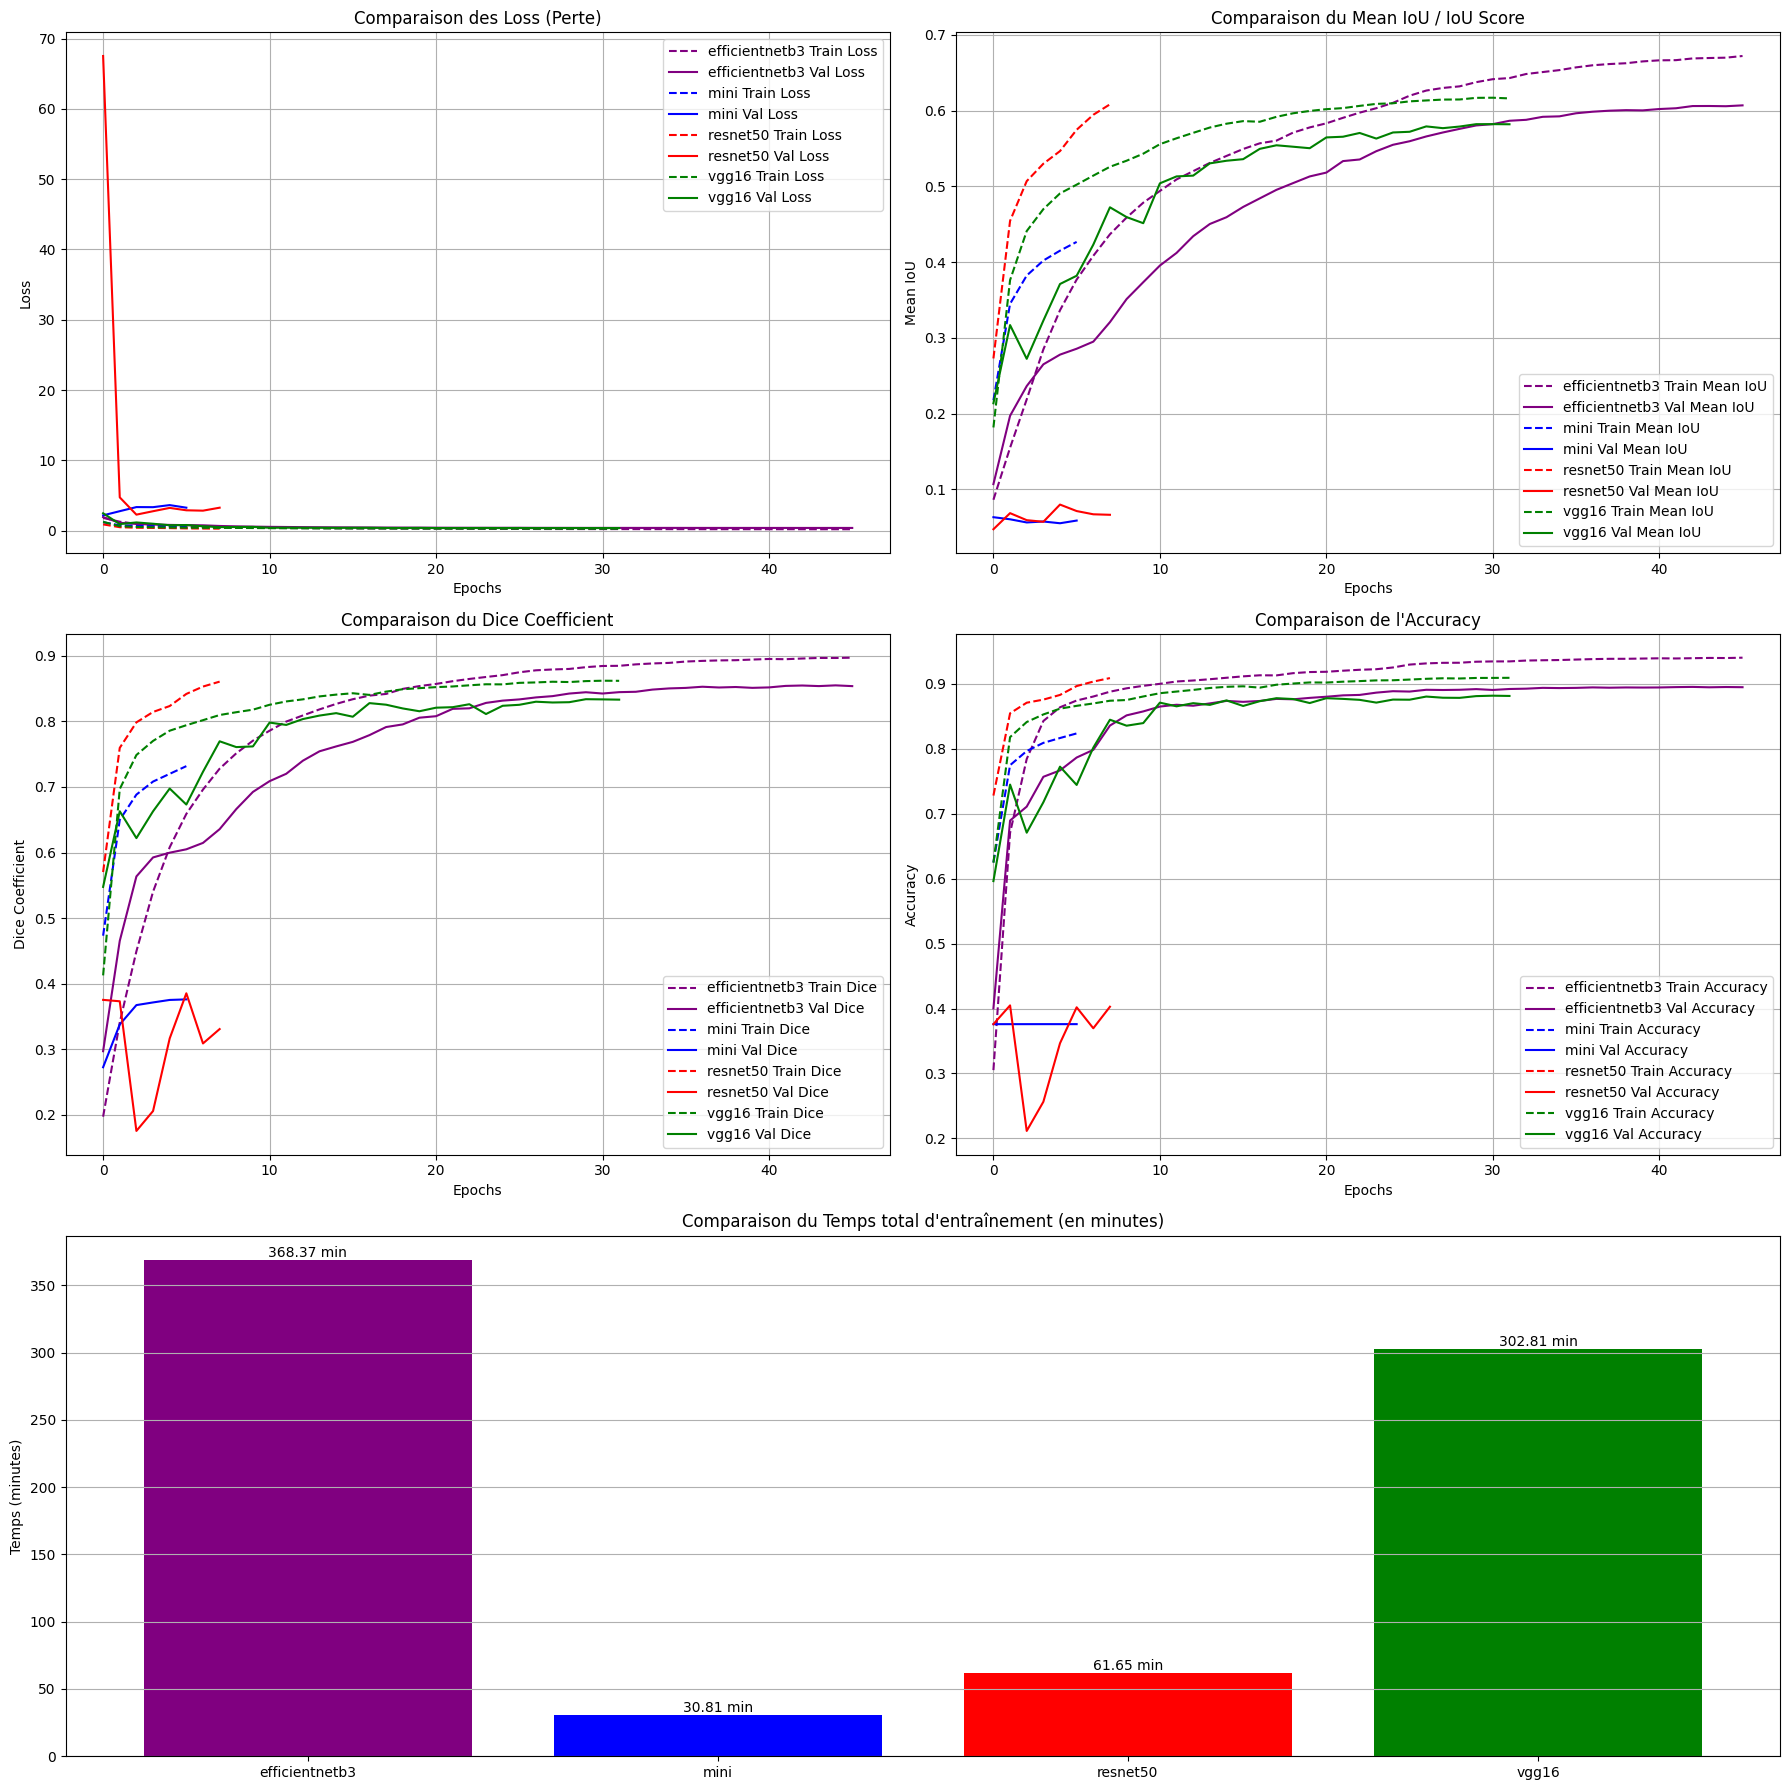

In [28]:
# Dossier contenant les fichiers CSV
dossier_logs = "test_modele"

# Chargement des résultats
resultats = fc.charger_metriques(dossier_logs)

# Tracer les résultats
fc.tracer_metriques(resultats)

In [31]:
"""import tensorflow as tf

# 1) Charger le modèle Keras
model = tf.keras.models.load_model("best_model.keras", compile=False)

# 2) Save au format HDF5
model.save("best_model.h5")

print("Modèle sauvegardé au format HDF5 dans best_model.h5.")"""

'import tensorflow as tf\n\n# 1) Charger le modèle Keras\nmodel = tf.keras.models.load_model("best_model.keras", compile=False)\n\n# 2) Save au format HDF5\nmodel.save("best_model.h5")\n\nprint("Modèle sauvegardé au format HDF5 dans best_model.h5.")'

In [32]:
################################
# Accès AWS (Amazon Web Services)
################################

# ssh -i p8-fastapi-key.pem ubuntu@35.180.51.112
# Activation venv : source ~/venv8b/bin/activate

################################
# Lancement API et APP
################################

# uvicorn main:app --host 0.0.0.0 --port 8000
# streamlit run app.py

################################
# URL
################################

# API : http://35.180.51.112:8000/docs
# App : http://35.180.51.112:8501/

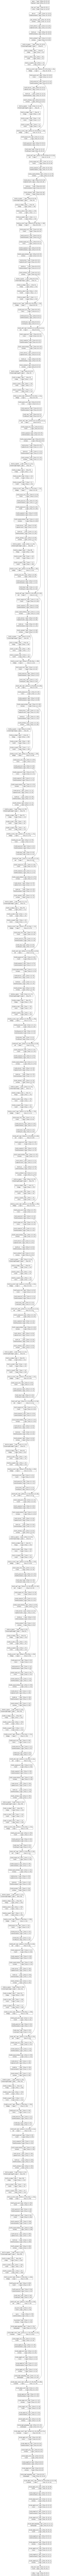

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import segmentation_models as sm

# Définition du modèle U-Net avec EfficientNetB3 comme backbone
sm.set_framework("tf.keras")
model = sm.Unet(
    backbone_name="efficientnetb3",
    encoder_weights="imagenet",
    input_shape=(256, 256, 3),
    classes=8,
    activation="softmax"
)

# Sauvegarde de l'architecture du modèle sous forme d'image
plot_model(model, to_file="unet_efficientnetb3.png", show_shapes=True, show_layer_names=True)

In [30]:
# Résumé détaillé des couches utilisées dans le modèle
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 40  1080        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 40  160         ['stem_conv[0][0]']              
                                )                                                             